# Variational AutoEncoder

**Description:** Convolutional Variational AutoEncoder (VAE) trained to generate 2D snapshots of the velocity amplitude of a turbulent flow on a rotating reference frame.

## Setup

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Load Data from your Google Drive



In [2]:
#Access Drive from Colab
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
#Read Data
xfile = h5py.File('MyDrive/TurbData_HandsOnML_small.h5', 'r')
Data = xfile['umod'][:]
xfile.close()

print(np.shape(Data))

(24999, 64, 64, 1)


In [4]:
def plot2DVelo():
    plt.figure(figsize=(5,5))
    random_inds = np.random.choice(np.shape(Data)[0],4)
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image_ind = random_inds[i]
        plt.imshow(np.squeeze(Data[image_ind]), cmap=plt.cm.coolwarm)



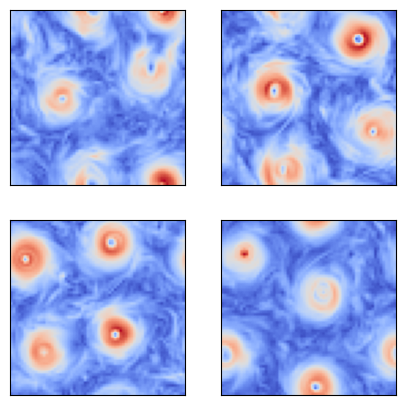

In [5]:
plot2DVelo()

## Dataset Normalization

In [6]:
ndata = np.shape(Data)[0]
ntrain =ndata

x_train = Data

print("Size of Train set: ", np.shape(x_train))

norm_max = np.max(x_train)
print("Normalization value: ", norm_max)


x_train /=  norm_max

input_shape = np.shape(x_train)
print("Input shape: ", input_shape)

Size of Train set:  (24999, 64, 64, 1)
Normalization value:  14.122704087083639
Input shape:  (24999, 64, 64, 1)


## Create a sampling layer

In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [100]:
#latent_dim = 8
latent_dim = 8

encoder_inputs = keras.Input(shape=(input_shape[1], input_shape[2], input_shape[3]))
x = layers.Conv2D(16, (3, 3), activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(8, (3, 3), activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

#Sample z from a Gaussian with mean = z_mean and variance = exp(z_log_var/2)^2
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

#Print Encoder Summary
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 32, 32, 16)           160       ['input_23[0][0]']            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 16, 16, 8)            1160      ['conv2d_22[0][0]']           
                                                                                                  
 flatten_11 (Flatten)        (None, 2048)                 0         ['conv2d_23[0][0]']           
                                                                                            

## Build the decoder

In [101]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 8, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 8))(x)
x = layers.Conv2DTranspose(8,  kernel_size=(3, 3), activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16,  kernel_size=(3, 3), activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1,  kernel_size=(3, 3), activation="relu", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

#Print Decoder Summary
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 8)]               0         
                                                                 
 dense_11 (Dense)            (None, 2048)              18432     
                                                                 
 reshape_11 (Reshape)        (None, 16, 16, 8)         0         
                                                                 
 conv2d_transpose_33 (Conv2  (None, 32, 32, 8)         584       
 DTranspose)                                                     
                                                                 
 conv2d_transpose_34 (Conv2  (None, 64, 64, 16)        1168      
 DTranspose)                                                     
                                                                 
 conv2d_transpose_35 (Conv2  (None, 64, 64, 1)         145 

## Define the VAE as a `Model` with a custom `train_step`

In [102]:
#beta = 0.7
beta = 0.8


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            decoded = self.decoder(z)
            mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
            reconstruction_loss = mse(data, decoded)
            #reconstruction_loss = tf.reduce_mean(
            #    tf.reduce_sum(
            #        keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            #    )
            #)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = (1-beta) * reconstruction_loss + beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

In [103]:
#Define the Variational AutoEncoder
vae = VAE(encoder, decoder)

#Choose a schedule for the learnng rate
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([5,10,15,20],[1e-2,5e-3,1e-3,5e-4,1e-4])

#Compile the model and specify the Optimizer
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))

In [104]:
#Train the model
TOT_EPOCHS = 40
DIM_BATCH =64

vae.fit(x_train,  shuffle=True, epochs=TOT_EPOCHS, batch_size=DIM_BATCH)

Epoch 1/40
391/391 [==============================] - 6s 8ms/step - loss: 1085.2224 - reconstruction_loss: 4999.6172 - kl_loss: 0.5605
Epoch 2/40
391/391 [==============================] - 3s 9ms/step - loss: 977.8139 - reconstruction_loss: 4884.7725 - kl_loss: 0.0051
Epoch 3/40
391/391 [==============================] - 4s 9ms/step - loss: 975.1545 - reconstruction_loss: 4871.2197 - kl_loss: 0.0671
Epoch 4/40
391/391 [==============================] - 3s 8ms/step - loss: 966.6121 - reconstruction_loss: 4611.0142 - kl_loss: 6.4636
Epoch 5/40
391/391 [==============================] - 3s 8ms/step - loss: 522.6076 - reconstruction_loss: 2183.6438 - kl_loss: 29.6826
Epoch 6/40
391/391 [==============================] - 3s 8ms/step - loss: 377.3867 - reconstruction_loss: 1727.0304 - kl_loss: 25.7380
Epoch 7/40
391/391 [==============================] - 4s 11ms/step - loss: 339.5446 - reconstruction_loss: 1576.2040 - kl_loss: 23.8922
Epoch 8/40
391/391 [==============================] - 4s 

# Data Generation

(10, 8)
1/1 [==============================] - 0s 88ms/step


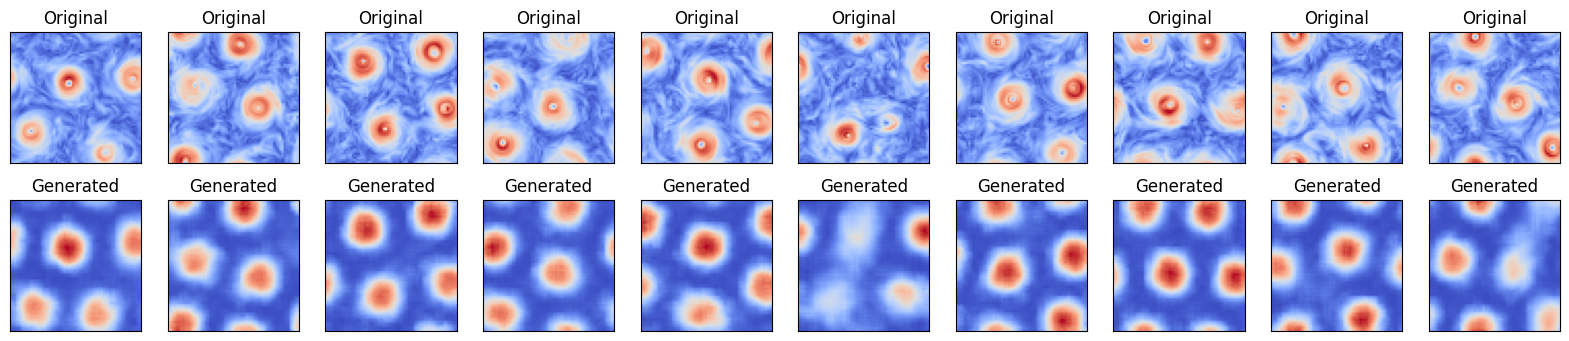

In [105]:
n = 10

z_mean, z_log_var, z_sample = vae.encoder(x_train[0:n])
print(z_sample.shape)

x_generated = vae.decoder.predict(z_sample)


plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i], cmap=plt.cm.coolwarm)
  plt.title("Original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display Generated images
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(x_generated[i], cmap=plt.cm.coolwarm)
  plt.title("Generated")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Sample the Latent Space from a Gaussian without any Encoding operation
(real generation step)

(10, 8)
1/1 [==============================] - 0s 17ms/step


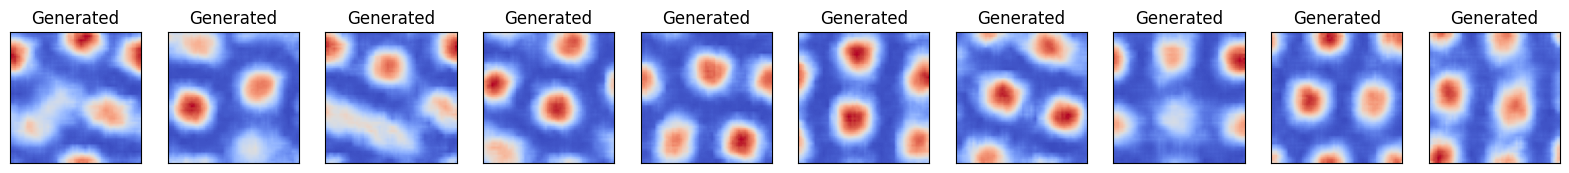

In [106]:
#Sample each entry on the latern space independently from a Standard Gaussian
#loc=0 specifies the mean of the distribution.
#scale=1 specifies the standard deviation (square root of the variance)
n = 10

z_sample = np.random.normal(loc=0, scale=1, size=[n, latent_dim])
print(z_sample.shape)

x_generated = vae.decoder.predict(z_sample)


plt.figure(figsize=(20, 4))
for i in range(n):
  # display Generated images
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(x_generated[i], cmap=plt.cm.coolwarm)
  plt.title("Generated")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()